### Importing dependencies



In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
!pip install statsmodels

### Exploration Data (EDA)

In [51]:
data_df = pd.read_csv("AEP_hourly.csv")
data_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [52]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [53]:
data_df.isna().sum()

,0
Datetime,0
AEP_MW,0


In [54]:
data_df["AEP_MW"].describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [55]:
data_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [56]:
data_df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [57]:
data_df.head(40)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


### Modeling

In [58]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [59]:
class TimeSerieDataset(Dataset):
  def __init__(self, inputs, sequence_length=10, stride=1):
    self.X = []
    self.y = []

    for i in range(0, len(inputs) - sequence_length, stride):
      X_i = inputs[i : i + sequence_length]
      y_i = inputs[i + sequence_length]

      self.X.append(torch.tensor(X_i, dtype=torch.float32))
      self.y.append(torch.tensor(y_i, dtype=torch.float32).unsqueeze(0))

  def __len__(self):
      return len(self.X)

  def __getitem__(self, idx):
      return self.X[idx], self.y[idx]

In [60]:
def dataloader(inputs, sequence_length=10, stride=1, shuffle=False, batch_size=4, num_workers=0):
  dataset = TimeSerieDataset(inputs, sequence_length, stride)

  dataloader = DataLoader(dataset=dataset, shuffle=shuffle,
                          batch_size=batch_size, num_workers=num_workers)
  return dataloader

In [61]:
data = data_df.AEP_MW

In [62]:
test_size = round(len(data) * 0.2)
print("data_len: ", len(data))
print("test_size: ", test_size)

data_len:  121273
test_size:  24255


In [63]:
input_test = data[:test_size]
input_train = data[test_size:]

print("input_test_size", len(input_test))
print("input_train_size", len(input_train))

input_test_size 24255
input_train_size 97018


In [64]:
print(input_train.shape)

(97018,)


In [65]:
train_dataset = TimeSerieDataset(inputs=input_train.to_numpy(), stride=1, sequence_length=1)

In [66]:
len(train_dataset)

97017

In [67]:
X_0, y_0 = train_dataset[0]
X_1, y_1 = train_dataset[1]

print(torch.Tensor.numpy(X_0), torch.Tensor.numpy(y_0))
print(torch.Tensor.numpy(X_1), torch.Tensor.numpy(y_1))

[21649.] [20432.]
[20432.] [18683.]


In [68]:
data_loader = dataloader(train_dataset, 1)

In [69]:
data_iter = iter(data_loader)
next(data_iter)

[tensor([[[21649.],
          [20432.]],
 
         [[20432.],
          [18683.]],
 
         [[18683.],
          [14075.]],
 
         [[14075.],
          [13536.]]]),
 tensor([[[20432., 18683.]],
 
         [[18683., 14075.]],
 
         [[14075., 13536.]],
 
         [[13536., 13108.]]])]

### ARIMA

In [70]:
from statsmodels.tsa.arima.model import ARIMA

In [71]:
data_train = TimeSerieDataset(input_train.to_numpy(), sequence_length=1, stride=1)
X_train = []
y_train = []

for i in range(0, len(data_train)):
  X, y = data_train[i]
  X_train.append(torch.Tensor.numpy(X)[0])
  y_train.append(torch.Tensor.numpy(y)[0])

X_train[:10], y_train[:10]

([np.float32(21649.0),
  np.float32(20432.0),
  np.float32(18683.0),
  np.float32(14075.0),
  np.float32(13536.0),
  np.float32(13108.0),
  np.float32(12982.0),
  np.float32(13064.0),
  np.float32(13785.0),
  np.float32(14732.0)],
 [np.float32(20432.0),
  np.float32(18683.0),
  np.float32(14075.0),
  np.float32(13536.0),
  np.float32(13108.0),
  np.float32(12982.0),
  np.float32(13064.0),
  np.float32(13785.0),
  np.float32(14732.0),
  np.float32(15719.0)])

In [94]:
arima_model = ARIMA(endog=X_train, order=(1, 0, 0))
res = arima_model.fit()
# print(res.summary())

# arima_model = ARIMA(endog=input_train.to_numpy(), order=(1, 0, 0))
# res = arima_model.fit()

In [95]:
y_pred = res.predict()

In [96]:
y_pred[:10]

array([15396.55729708, 21466.05562746, 20284.66463852, 18586.83979082,
       14113.66832244, 13590.43928133, 13174.96241751, 13052.64913517,
       13132.24984273, 13832.153625  ])

In [119]:
from sklearn.metrics import mean_squared_error

mse_arima_train = mean_squared_error(y_train, y_pred)
print("MSE_arima_model: ", mse_arima_train)

MSE_arima_model:  1250099.61123734


In [98]:
def diff_y_pred_y_truth(y_pred, y_truth):
  return abs(y_pred - y_truth)

In [99]:
diff_y_pred_y_truth_arr = [diff_y_pred_y_truth(y_pred[i], y_train[i]) for i in range(0, len(X_train))]

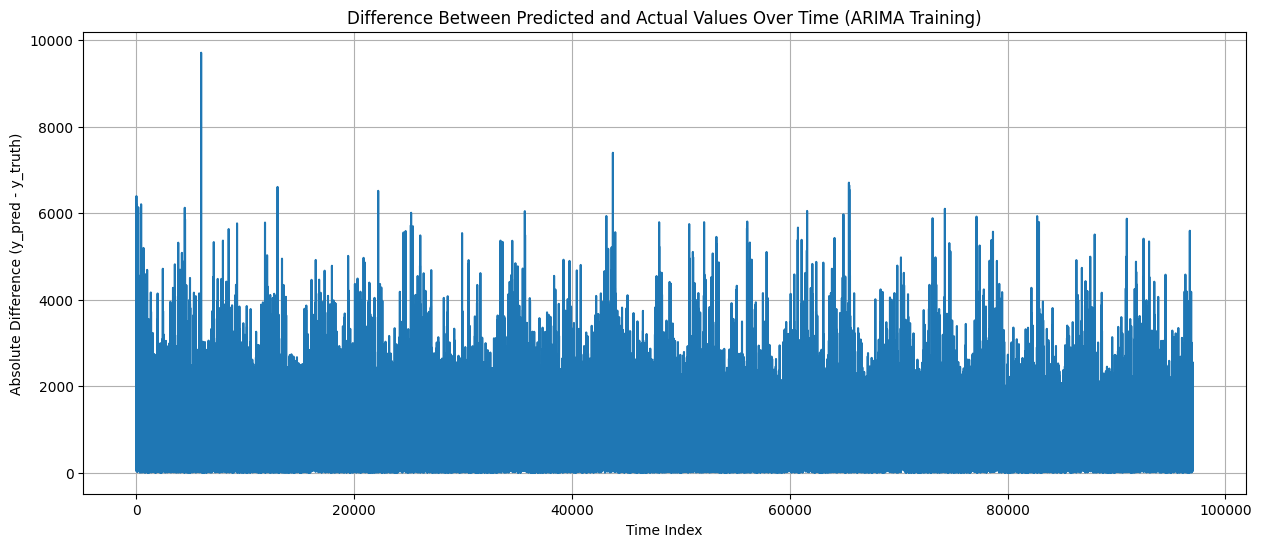

In [109]:
plt.figure(figsize=(15, 6))
plt.plot(diff_y_pred_y_truth_arr)
plt.title('Difference Between Predicted and Actual Values Over Time (ARIMA Training)')
plt.xlabel('Time Index')
plt.ylabel('Absolute Difference (y_pred - y_truth)')
plt.grid(True)
plt.show()

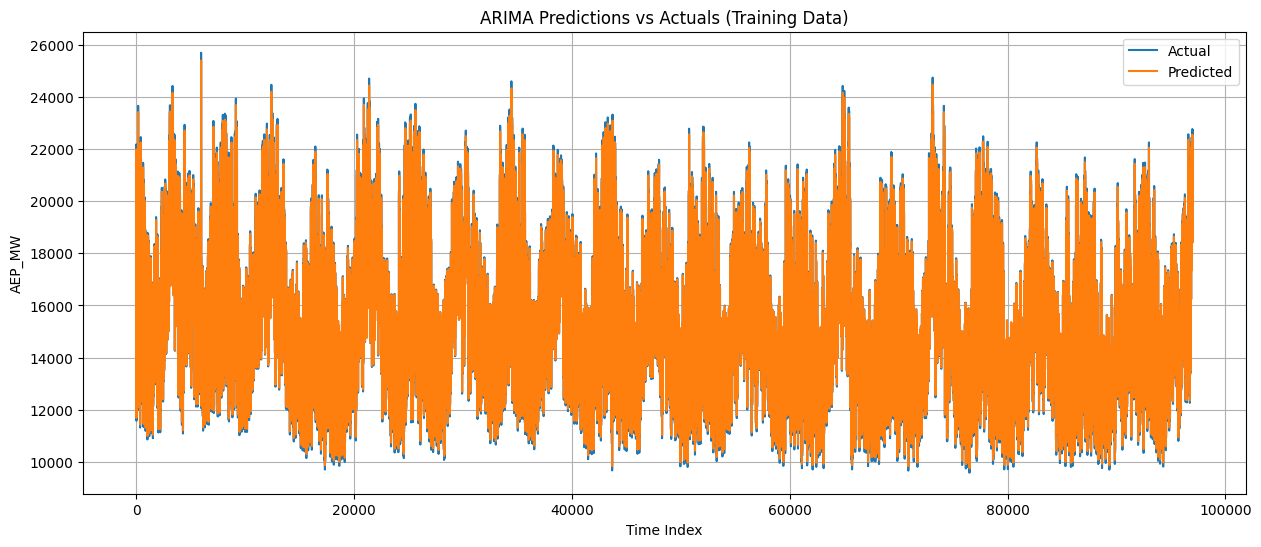

In [118]:
plt.figure(figsize=(15, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('ARIMA Predictions vs Actuals (Training Data)')
plt.xlabel('Time Index')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True)
plt.show()

### LSTM

In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### LSTM Model Definition

In [112]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))

        out = self.fc(out[:, -1, :])
        return out

### Prepare Data for LSTM

In [113]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.to_numpy().reshape(-1, 1))

test_size_scaled = round(len(scaled_data) * 0.2)
input_train_scaled = scaled_data[test_size_scaled:]
input_test_scaled = scaled_data[:test_size_scaled]

sequence_length = 1

train_dataset_lstm = TimeSerieDataset(inputs=input_train_scaled.flatten(), sequence_length=sequence_length, stride=1)
test_dataset_lstm = TimeSerieDataset(inputs=input_test_scaled.flatten(), sequence_length=sequence_length, stride=1)

batch_size = 64

train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size, shuffle=False)

### LSTM Model Training

In [114]:
input_size = 1
hidden_size = 50
output_size = 1
num_layers = 2

model = LSTM(input_size, hidden_size, output_size, num_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

print("Starting LSTM training...")
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader_lstm:
        X_batch = X_batch.unsqueeze(-1)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
print("LSTM training complete.")

Starting LSTM training...
Epoch [1/10], Loss: 0.0013
Epoch [2/10], Loss: 0.0013
Epoch [3/10], Loss: 0.0017
Epoch [4/10], Loss: 0.0016
Epoch [5/10], Loss: 0.0015
Epoch [6/10], Loss: 0.0015
Epoch [7/10], Loss: 0.0030
Epoch [8/10], Loss: 0.0014
Epoch [9/10], Loss: 0.0011
Epoch [10/10], Loss: 0.0015
LSTM training complete.


### LSTM Model Evaluation and MSE Over Time

MSE for LSTM on test set: 434007.1250


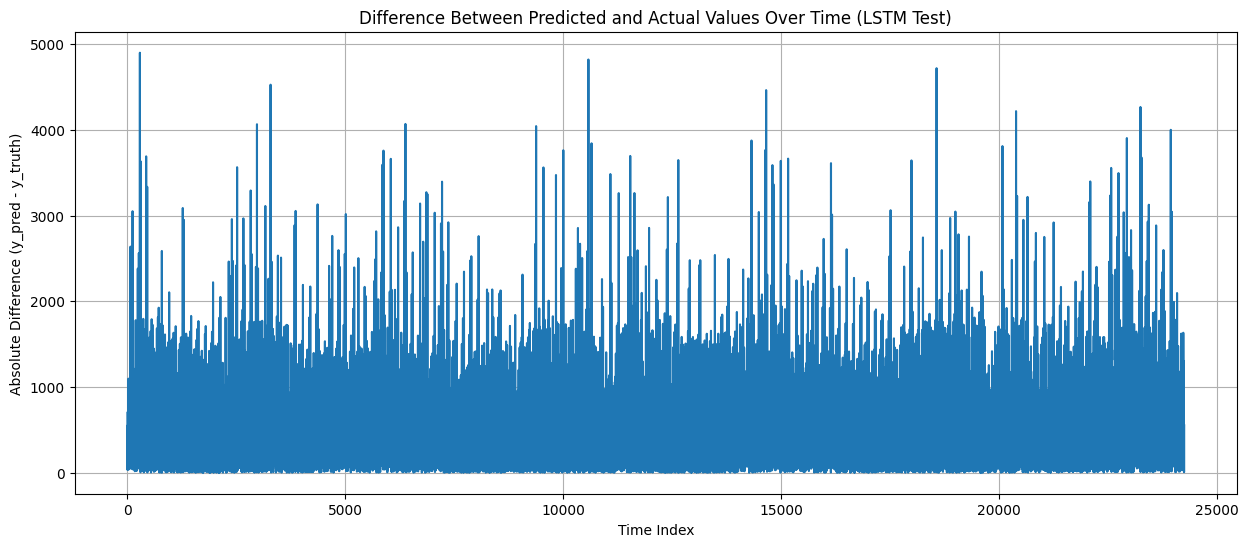

In [115]:
model.eval()
predictions_lstm = []
actuals_lstm = []

with torch.no_grad():
    for X_batch, y_batch in test_loader_lstm:
        X_batch = X_batch.unsqueeze(-1)
        outputs = model(X_batch)
        predictions_lstm.extend(outputs.cpu().numpy().flatten())
        actuals_lstm.extend(y_batch.cpu().numpy().flatten())

predictions_lstm_original_scale = scaler.inverse_transform(np.array(predictions_lstm).reshape(-1, 1))
actuals_lstm_original_scale = scaler.inverse_transform(np.array(actuals_lstm).reshape(-1, 1))

mse_lstm = mean_squared_error(actuals_lstm_original_scale, predictions_lstm_original_scale)
print(f"MSE for LSTM on test set: {mse_lstm:.4f}")

diff_lstm_pred_actual = np.abs(predictions_lstm_original_scale.flatten() - actuals_lstm_original_scale.flatten())

plt.figure(figsize=(15, 6))
plt.plot(diff_lstm_pred_actual)
plt.title('Difference Between Predicted and Actual Values Over Time (LSTM Test)')
plt.xlabel('Time Index')
plt.ylabel('Absolute Difference (y_pred - y_truth)')
plt.grid(True)
plt.show()


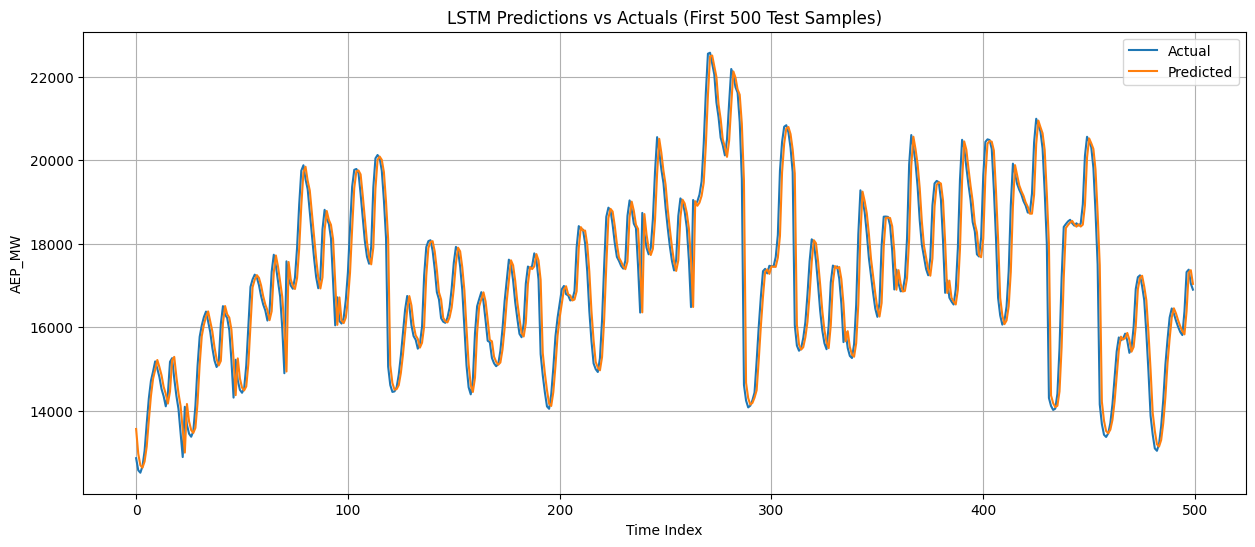

In [116]:
plt.figure(figsize=(15, 6))
plt.plot(actuals_lstm_original_scale[:500], label='Actual')
plt.plot(predictions_lstm_original_scale[:500], label='Predicted')
plt.title('LSTM Predictions vs Actuals (First 500 Test Samples)')
plt.xlabel('Time Index')
plt.ylabel('AEP_MW')
plt.legend()
plt.grid(True)
plt.show()